In [1]:
import pandas as pd
import math
import datetime as dt
import time
import json
import numpy as np
import warnings
import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

import torch
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import sklearn
from sklearn import svm

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
from Sleep_stress_exclude_sms_call import preprocessing

#  No call nor sms data

In [3]:
uid_list = ['u00', 'u01', 'u02', 'u03', 'u04', 'u07', 'u08', 'u09', 'u10', 'u12', #'u13',
            'u14', 'u15', 'u16', 'u17',
      'u18', 'u19', 'u20', 'u22', 'u23', 'u24', 'u25', 'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36', 
      'u39', 'u41', 'u42', 'u43', 'u44', 'u45', 'u46', 'u47','u49', 'u50', 'u51', 'u52', 'u53', 'u54', 'u56', 
      'u57', 'u58' ,'u59']

dataframes = []
for uid in uid_list:
    df = preprocessing(uid)
    dataframes.append((uid, df))
    print(uid, len(df))

u00 10
u01 9
u02 7
u03 5
u04 10
u07 5
u08 25
u09 1
u10 13
u12 7
u14 10
u15 2
u16 26
u17 8
u18 4
u19 24
u20 3
u22 6
u23 15
u24 8
u25 3
u27 4
u30 9
u31 2
u32 14
u33 14
u34 2
u35 2
u36 12
u39 0
u41 1
u42 2
u43 15
u44 15
u45 5
u46 6
u47 1
u49 5
u50 0
u51 6
u52 9
u53 7
u54 3
u56 0
u57 13
u58 14
u59 35


# Predicting Stress and Sleep:

In [4]:
def transform_df(dataframe):
    ## obtain the dates as a column and re-index the dataframes
    re_index_data = []

    for tup in dataframe:
        test = tup[1]
        test = test.rename_axis('date').reset_index()
        re_index_data.append((tup[0], test))
    return re_index_data

In [5]:
transformed_data = transform_df(dataframes)

In [6]:
transformed_dataframes = [tup[1] for tup in transformed_data]

In [7]:
df3 = pd.concat(transformed_dataframes)
df3 = df3.sort_values(by='date')
max_range = len(df3)
df3 = df3.drop(['date', "Mean_rate_sleep", "Mean_social_sleep",
              "Std_hour_sleep", "Std_rate_sleep", "Std_social_sleep", 
              'Median_hour_sleep', 'Median_rate_sleep', 'Median_social_sleep',
              'Min_hour_sleep', 'Min_rate_sleep', 'Min_social_sleep', 
              'Max_hour_sleep', 'Max_rate_sleep', 'Max_social_sleep',
              'Skew_hour_sleep', 'Skew_rate_sleep', 'Skew_social_sleep',
              'Var_hour_sleep', 'Var_rate_sleep', 'Var_social_sleep'], axis=1)
df3 = df3.reset_index(drop=True)
df3

,Mean_Activity_inference,Std_Activity_inference,Median_Activity_inference,Min_Activity_inference,Max_Activity_inference,Skew_Activity_inference,Var_Activity_inference,Sum_Activity_inference,Mean_audio_inference,Std_audio_inference,...,Var_number_social,Sum_number_social,Mean_stress_level,Std_stress_level,Median_stress_level,Min_stress_level,Max_stress_level,Skew_stress_level,Var_stress_level,Sum_stress_level
0,0.294428,0.695228,0,0,3,2.533992,0.483342,1955,0,0.732571,...,0.000000,4,1.000000,0.000000,1.0,1,1,0.000000,0.000000,1
1,0.152590,0.496856,0,0,3,3.598265,0.246866,1028,0,0.835018,...,0.000000,3,2.500000,1.500000,2.5,1,4,0.000000,2.250000,5
2,0.138539,0.437443,0,0,3,3.732708,0.191357,935,0,0.783262,...,0.000000,6,2.166667,1.343710,1.5,1,4,0.710722,1.805556,13
3,0.248774,0.692781,0,0,3,2.754788,0.479945,1674,0,0.867151,...,0.000000,4,4.500000,0.500000,4.5,4,5,0.000000,0.250000,9
4,0.132745,0.446104,0,0,3,4.058229,0.199009,902,0,0.732716,...,0.222222,7,2.000000,1.309307,1.0,1,4,0.989949,1.714286,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.101164,0.440019,0,0,3,4.964656,0.193617,3121,0,0.827521,...,0.000000,8,2.000000,0.000000,2.0,2,2,0.000000,0.000000,6
393,0.056297,0.312272,0,0,3,6.886170,0.097514,898,0,0.769917,...,0.000000,4,5.000000,0.000000,5.0,5,5,0.000000,0.000000,5
394,0.191936,0.580720,0,0,3,3.451111,0.337236,7288,0,0.878100,...,0.000000,5,3.500000,1.500000,3.5,2,5,0.000000,2.250000,7
395,0.117769,0.455390,0,0,3,4.369397,0.207380,1871,0,0.798978,...,0.000000,3,2.000000,0.000000,2.0,2,2,0.000000,0.000000,2


# Correlation Analysis:

In [8]:
correlation_df = df3.corr()
correlation_df

,Mean_Activity_inference,Std_Activity_inference,Median_Activity_inference,Min_Activity_inference,Max_Activity_inference,Skew_Activity_inference,Var_Activity_inference,Sum_Activity_inference,Mean_audio_inference,Std_audio_inference,...,Var_number_social,Sum_number_social,Mean_stress_level,Std_stress_level,Median_stress_level,Min_stress_level,Max_stress_level,Skew_stress_level,Var_stress_level,Sum_stress_level
Mean_Activity_inference,1.000000,0.743307,0.684218,NaN,NaN,-0.375036,0.774368,0.658959,0.413569,0.172074,...,0.015749,0.264528,0.099943,0.264059,0.027805,-0.004041,0.250252,0.169547,0.307014,0.309669
Std_Activity_inference,0.743307,1.000000,0.105613,NaN,NaN,-0.569798,0.957683,0.697625,0.507639,0.346982,...,0.048321,0.382441,0.048115,0.262448,-0.030599,-0.049934,0.220339,0.216127,0.272277,0.333413
Median_Activity_inference,0.684218,0.105613,1.000000,NaN,NaN,-0.107691,0.089128,0.224192,-0.021425,-0.041477,...,-0.021442,-0.043173,0.119908,0.084955,0.116097,0.073726,0.128832,-0.011972,0.136997,0.053248
Min_Activity_inference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max_Activity_inference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Min_stress_level,-0.004041,-0.049934,0.073726,NaN,NaN,0.002588,-0.066101,-0.053375,-0.057831,-0.044936,...,-0.004999,-0.066899,0.872259,-0.355402,0.854698,1.000000,0.529275,-0.126795,-0.328006,0.133291
Max_stress_level,0.250252,0.220339,0.128832,NaN,NaN,-0.134284,0.226478,0.317450,0.148286,0.118887,...,0.030373,0.205699,0.846238,0.596366,0.734401,0.529275,1.000000,0.110412,0.581811,0.721714
Skew_stress_level,0.169547,0.216127,-0.011972,NaN,NaN,-0.089739,0.239184,0.149909,0.134519,0.113237,...,0.047626,0.191980,-0.171653,0.211438,-0.357740,-0.126795,0.110412,1.000000,0.169746,0.090468
Var_stress_level,0.307014,0.272277,0.136997,NaN,NaN,-0.133094,0.296287,0.396717,0.232388,0.148835,...,-0.001161,0.229775,0.125374,0.965090,0.022218,-0.328006,0.581811,0.169746,1.000000,0.581826


In [9]:
## Investigate correlation analysis with only the label 

In [10]:
correlation_df['Mean_hour_sleep'].dropna().sort_values(ascending=False)[:20]

Mean_hour_sleep              1.000000
Var_phone_lock_duration      0.265150
Max_phone_lock_duration      0.262173
Std_phone_lock_duration      0.246781
Var_dark_duration            0.171260
Max_dark_duration            0.134019
Mean_phone_lock_duration     0.133736
Skew_phone_lock_duration     0.128835
Std_dark_duration            0.125100
Var_phone_charge_duration    0.123267
Skew_Activity_inference      0.121781
Mean_dark_duration           0.117420
Min_pic_id                   0.116842
Skew_audio_inference         0.102650
Skew_number_social           0.094045
Mean_pic_id                  0.087377
Median_dark_duration         0.087018
Min_longitude                0.085719
Min_latitude                 0.081939
Mean_longitude               0.069969
Name: Mean_hour_sleep, dtype: float64

In [11]:
#fig, axs = plt.subplots(1,1, figsize=(14,10))
#s = 100

#axs.scatter(df3['Mean_stress_level'],df3['number of distinct locations'], s=100, zorder=-5)

#for axis in ['top','bottom','left','right']:
 #   axs.spines[axis].set_linewidth(6)
    
#axs.grid(True)
#axs.set_ylabel('Number of distinct locations', fontsize=60)
#axs.xaxis.set_ticks_position('both')
#axs.set_xlabel('Mean stress level', fontsize=60)
#axs.yaxis.set_ticks_position('both')
#axs.tick_params(which='both', length=30, width=6, direction="in", pad=10)


#axs.tick_params(labelsize=35)

#plt.tight_layout()

# Feature Vector:

In [12]:
df4 = df3.drop(['Mean_hour_sleep'], axis=1)
X = df4.to_numpy()
## 0 -> Not enough sleep
## 1 -> Enough sleep
y = np.array([0 if val<9 else 1 for val in df3['Mean_hour_sleep']])
y = y.astype('int')

In [13]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)

The shape of X is (397, 91)
The shape of y is (397,)


## Feature Normalization:

In [14]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

## Feature Selection:

In [15]:
estimator = RandomForestClassifier(n_estimators = 100)
sel = RFECV(estimator, step=1, cv=5)
sel.fit(X_norm, y)

RFECV(cv=5, estimator=RandomForestClassifier())

In [16]:
sel.get_support()

array([ True,  True, False, False, False,  True,  True,  True, False,
        True, False, False, False,  True,  True,  True, False,  True,
        True,  True,  True, False, False,  True, False,  True,  True,
        True, False, False,  True, False, False,  True,  True,  True,
        True,  True, False,  True, False, False,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True, False, False, False, False,  True,  True,
        True, False, False,  True, False,  True, False, False,  True,
        True,  True,  True,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [17]:
feature_name = df4.columns.to_numpy()
important_features = feature_name[sel.get_support()]
important_features

array(['Mean_Activity_inference', 'Std_Activity_inference',
       'Skew_Activity_inference', 'Var_Activity_inference',
       'Sum_Activity_inference', 'Std_audio_inference',
       'Skew_audio_inference', 'Var_audio_inference',
       'Sum_audio_inference', 'Std_conv_duration', 'Median_conv_duration',
       'Min_conv_duration', 'Max_conv_duration', 'Mean_dark_duration',
       'Median_dark_duration', 'Min_dark_duration', 'Max_dark_duration',
       'Mean_latitude', 'Std_latitude', 'Std_longitude',
       'Std_travelstate', 'Median_latitude', 'Median_longitude',
       'Min_latitude', 'Max_latitude', 'Max_longitude', 'Skew_latitude',
       'Skew_longitude', 'Skew_travelstate', 'Var_longitude',
       'Var_travelstate', 'Sum_travelstate', 'Mean_phone_charge_duration',
       'Median_phone_charge_duration', 'Min_phone_charge_duration',
       'Max_phone_charge_duration', 'Median_phone_lock_duration',
       'Min_phone_lock_duration', 'Max_phone_lock_duration',
       'number of distin

In [18]:
X_important = X_norm[:,sel.get_support()]

In [19]:
X_important.shape

(397, 47)

## Train, Test split:

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_important,y, test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((277, 47), (120, 47), (277,), (120,))

# XGBoost: 

In [24]:
xgb_model = XGBClassifier(booster = 'gbtree', use_label_encoder=False)
xgb_tree_parameters = {'eta': [0.1, 0.01], 'max_depth':[6, 7, 8],
                       'learning_rate': [0.05, 0.005],
                      'sampling_method':['uniform', 'gradient_based'], 
                      'tree_method': ['auto'], 'max_bin': [64, 128],
                      'lambda':[1, 0.1, 0.01], 'alpha':[1, 0.1, 0.01]}

In [25]:
%%time
xgb_tree = GridSearchCV(xgb_model, xgb_tree_parameters, refit=True, n_jobs = -1, verbose=2) ## 5 cross val folds
xgb_tree.fit(X_train, y_train, eval_metric= 'logloss')
xgb_tree_best = xgb_tree.best_estimator_

print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_tree.predict(X_val)))
print('\n')
print('*'*20, 'Best estimator:', '*'*20, '\n', xgb_tree.best_estimator_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       103
           1       0.00      0.00      0.00        17

    accuracy                           0.85       120
   macro avg       0.43      0.50      0.46       120
weighted avg       0.74      0.85      0.79       120



******************** Best estimator: ******************** 
 XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=0.1, learning_rate=0.05, max_bin=64, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alph

In [26]:
feat_importances_xgb_tree = pd.DataFrame(zip(important_features, 
                                             xgb_tree_best.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [27]:
#feat_importances_xgb_tree

In [28]:
ordered_feat_imp_tree = feat_importances_xgb_tree.sort_values(by=['Importance'])

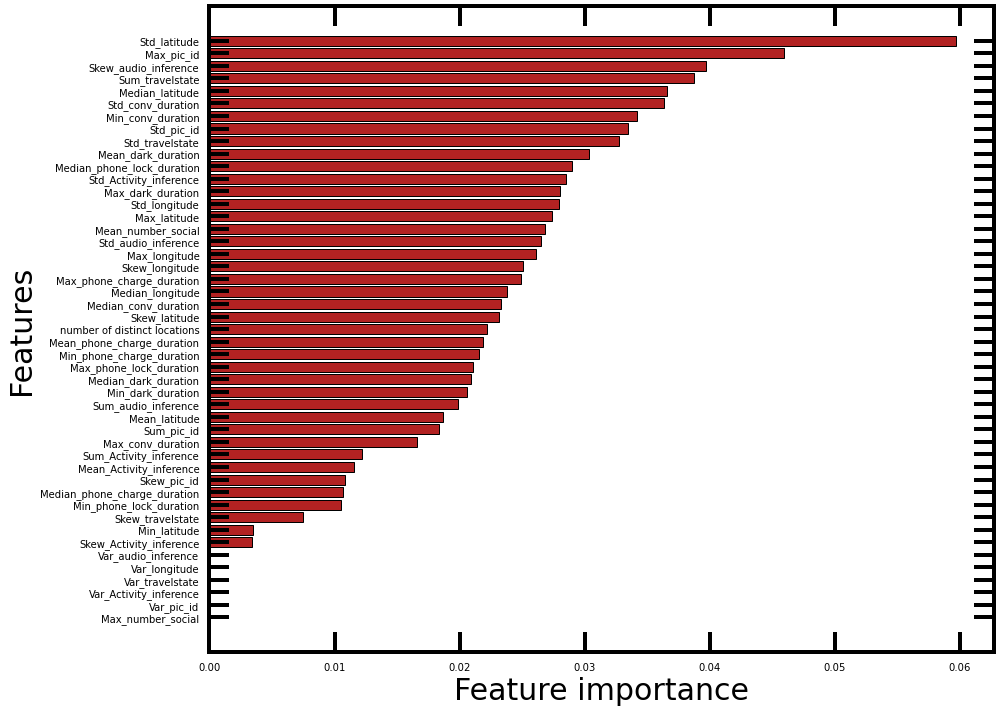

In [29]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_tree['Features'], ordered_feat_imp_tree['Importance'], ec='black', color='firebrick')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_xlabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)

axs.tick_params(labelsize=10)

plt.tight_layout()
#fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/xgb_tree_feat_imp_no_txt_no_call', bbox_inches='tight')

In [30]:
xgb_model = XGBClassifier(booster = 'gblinear', use_label_encoder=False)
xgb_linear_parameters = {'updater': ['shotgun', 'coord_descent'],
                        'feature_selector': ['cyclic', 'shuffle'],
                        'lambda':[1, 0.1, 0.01], 'alpha':[1, 0.1, 0.01]}

In [31]:
%%time
xgb_linear = GridSearchCV(xgb_model, xgb_linear_parameters, refit=True, n_jobs = -1, verbose=2)
xgb_linear.fit(X_train, y_train, eval_metric= 'logloss')
xgb_linear_best = xgb_linear.best_estimator_
print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_linear_best.predict(X_val)))
print('\n')
print('Best estimator:', xgb_linear.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       103
           1       0.00      0.00      0.00        17

    accuracy                           0.86       120
   macro avg       0.43      0.50      0.46       120
weighted avg       0.74      0.86      0.79       120



Best estimator: XGBClassifier(alpha=1, base_score=0.5, booster='gblinear',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, feature_selector='cyclic', gamma=None,
              gpu_id=-1, importance_type='gain', interaction_constraints=None,
              lambda=1, learning_rate=0.5, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              random_state=0, reg_alpha=0,

The concept of feature importance is specific to decision trees, as the definition specifically refers to "splits"

In [32]:
xgb_model = XGBClassifier(booster = 'dart',use_label_encoder=False)
xgb_dart_parameters = {'sample_type': ['uniform'],
                      'normalize_type': ['tree', 'forest'], 'rate_drop': [0.1],
                       'skip_drop': [0.2,0.5], 'learning_rate':[0.2, 0.1, 0.01, 0.3, 0.02, 0.03, 0.5],
                      'eta': [0.01], 'max_depth': [6, 8], 'lambda':[1, 0.1, 0.01], 
                       'alpha':[0.1, 0.01]}

In [33]:
%%time
xgb_dart = GridSearchCV(xgb_model, xgb_dart_parameters, refit=True, n_jobs = -1, verbose=2)
xgb_dart.fit(X_train, y_train, eval_metric='logloss')
xgb_dart_best = xgb_dart.best_estimator_
print('*'*20, 'Validation', '*'*20)
print(classification_report(y_val, xgb_dart_best.predict(X_val)))
print('\n')
print('Best estimator:', xgb_dart.best_estimator_)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
******************** Validation ********************
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       103
           1       0.00      0.00      0.00        17

    accuracy                           0.84       120
   macro avg       0.43      0.49      0.46       120
weighted avg       0.73      0.84      0.78       120



Best estimator: XGBClassifier(alpha=0.01, base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=0.1, learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, normalize_type='tree',
              num_parallel_tree=1, random_state=0, rate_drop=0.1,
              reg_alpha=0.00

In [34]:
feat_importances_xgb_dart = pd.DataFrame(zip(important_features, 
                                             xgb_dart_best.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [37]:
ordered_feat_imp_dart = feat_importances_xgb_dart.sort_values(by= ['Importance'])

In [38]:
ordered_feat_imp_dart = ordered_feat_imp_dart.reset_index()

In [45]:
ordered_feat_imp_dart

,index,Features,Importance
0,29,Var_longitude,0.000000
1,3,Var_Activity_inference,0.000000
2,30,Var_travelstate,0.000000
3,43,Var_pic_id,0.000000
4,28,Skew_travelstate,0.000000
5,7,Var_audio_inference,0.000000
6,2,Skew_Activity_inference,0.006176
7,23,Min_latitude,0.006573
8,37,Min_phone_lock_duration,0.007059
9,4,Sum_Activity_inference,0.009888


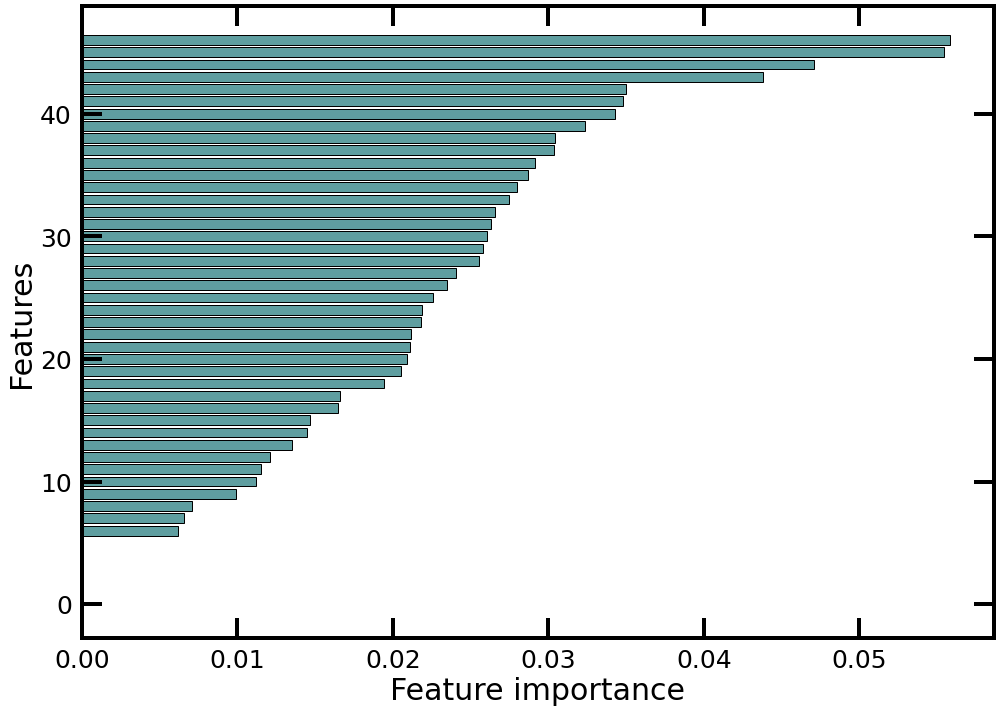

In [39]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_dart.index, ordered_feat_imp_dart['Importance'], ec='black', 
         color='cadetblue')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_xlabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_ylabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)

axs.tick_params(labelsize=25)

plt.tight_layout()
#fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/xgb_dart_feat_imp_no_txt_no_call.svg', bbox_inches='tight')

# TabNet:

In [40]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [88]:
clf1 = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                        n_d=8, n_a=8, n_steps=3, 
                        gamma=1.3, n_independent=3, n_shared=4, epsilon=1e-15, 
                        momentum=0.01, lambda_sparse=0.001, seed=0, clip_value=2, verbose=1, 
                       optimizer_params={'lr': 1e-3, 'weight_decay': 1e-3},
                        scheduler_params={'step_size':50,
                                         "gamma":0.90},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


In [89]:
clf1.fit(
    X_train,y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=1000 , patience=70,
    loss_fn = torch.nn.CrossEntropyLoss(),
    batch_size=256, virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 0.9404  | train_accuracy: 0.32852 | valid_accuracy: 0.26667 |  0:00:00s
epoch 1  | loss: 0.81614 | train_accuracy: 0.30325 | valid_accuracy: 0.30833 |  0:00:00s
epoch 2  | loss: 0.94238 | train_accuracy: 0.34657 | valid_accuracy: 0.30833 |  0:00:00s
epoch 3  | loss: 0.92451 | train_accuracy: 0.36101 | valid_accuracy: 0.34167 |  0:00:00s
epoch 4  | loss: 0.91124 | train_accuracy: 0.3574  | valid_accuracy: 0.39167 |  0:00:00s
epoch 5  | loss: 0.89927 | train_accuracy: 0.37906 | valid_accuracy: 0.40833 |  0:00:00s
epoch 6  | loss: 0.85204 | train_accuracy: 0.38989 | valid_accuracy: 0.45    |  0:00:01s
epoch 7  | loss: 0.82916 | train_accuracy: 0.39711 | valid_accuracy: 0.45833 |  0:00:01s
epoch 8  | loss: 0.9188  | train_accuracy: 0.39711 | valid_accuracy: 0.425   |  0:00:01s
epoch 9  | loss: 0.8754  | train_accuracy: 0.40433 | valid_accuracy: 0.43333 |  0:00:01s
epoch 10 | loss: 0.82157 | train_accuracy: 0.4296  | valid_accuracy: 0.43333 |  0:00:01s
epoch 11 | loss: 0.90

epoch 94 | loss: 0.68076 | train_accuracy: 0.81588 | valid_accuracy: 0.83333 |  0:00:15s
epoch 95 | loss: 0.65084 | train_accuracy: 0.81588 | valid_accuracy: 0.83333 |  0:00:15s
epoch 96 | loss: 0.67221 | train_accuracy: 0.81588 | valid_accuracy: 0.84167 |  0:00:15s
epoch 97 | loss: 0.63047 | train_accuracy: 0.81949 | valid_accuracy: 0.84167 |  0:00:16s
epoch 98 | loss: 0.66879 | train_accuracy: 0.81949 | valid_accuracy: 0.83333 |  0:00:16s
epoch 99 | loss: 0.69104 | train_accuracy: 0.81949 | valid_accuracy: 0.825   |  0:00:16s
epoch 100| loss: 0.66172 | train_accuracy: 0.81227 | valid_accuracy: 0.81667 |  0:00:16s
epoch 101| loss: 0.65419 | train_accuracy: 0.81227 | valid_accuracy: 0.80833 |  0:00:16s
epoch 102| loss: 0.61411 | train_accuracy: 0.80866 | valid_accuracy: 0.81667 |  0:00:16s
epoch 103| loss: 0.70738 | train_accuracy: 0.81227 | valid_accuracy: 0.80833 |  0:00:16s
epoch 104| loss: 0.61419 | train_accuracy: 0.80866 | valid_accuracy: 0.80833 |  0:00:17s
epoch 105| loss: 0.70

In [72]:
preds_valid = clf1.predict(X_val)
valid_acc = accuracy_score(preds_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.8416666666666667


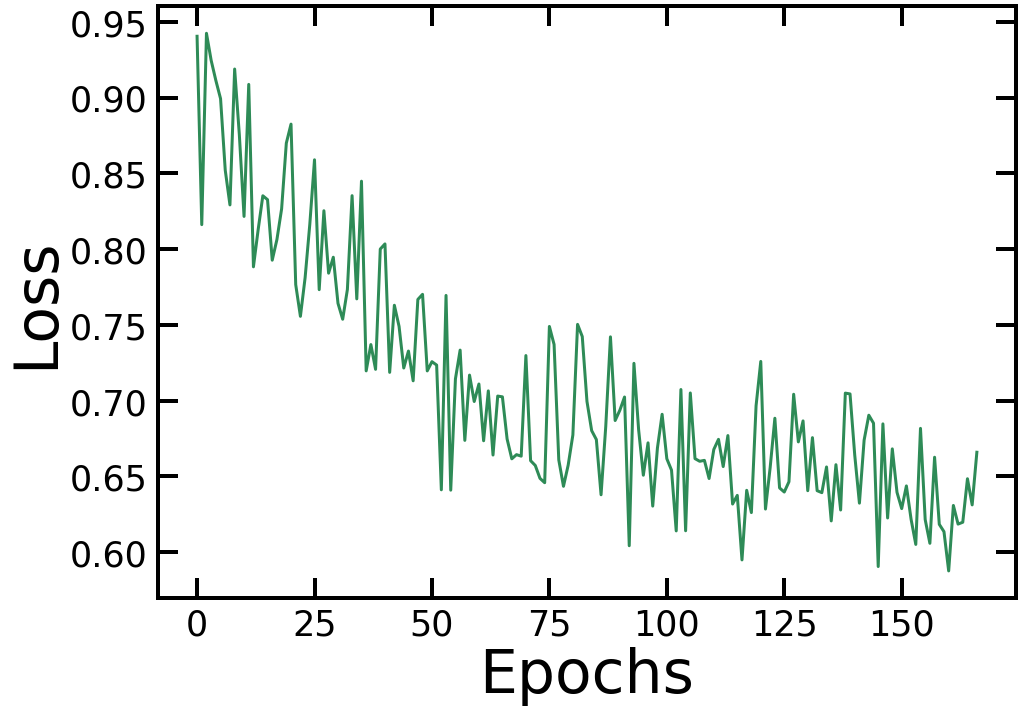

In [74]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['loss'], linewidth=3, color='seagreen')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Loss', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleep_tab_net_loss_no_txt_no_call.svg', bbox_inches='tight')

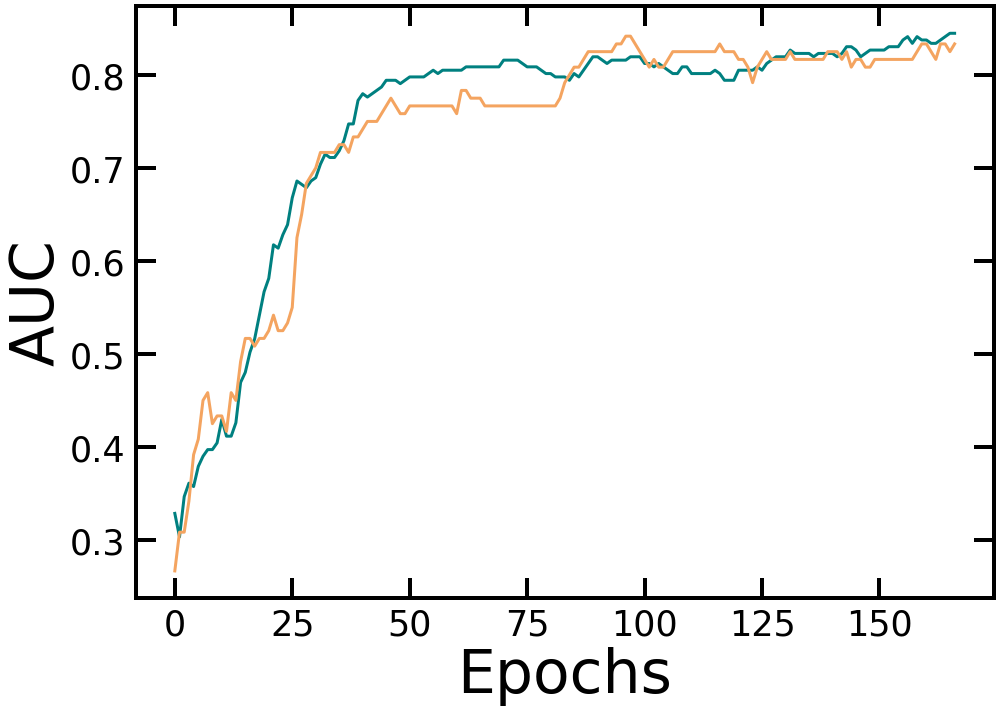

In [76]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['train_accuracy'], linewidth=3, label = 'Training AUC', color='teal')
axs.plot(clf1.history['valid_accuracy'], linewidth=3, label = 'Validation AUC', color='sandybrown')
for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('AUC', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)
#legend = axs.legend(borderpad=1, labelspacing=2, fontsize=15)
#legend.get_frame().set_linewidth(2.5)
#legend.get_frame().set_edgecolor('black')

axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleep_tabnet_auc_no_txt_no_call.svg', bbox_inches='tight')

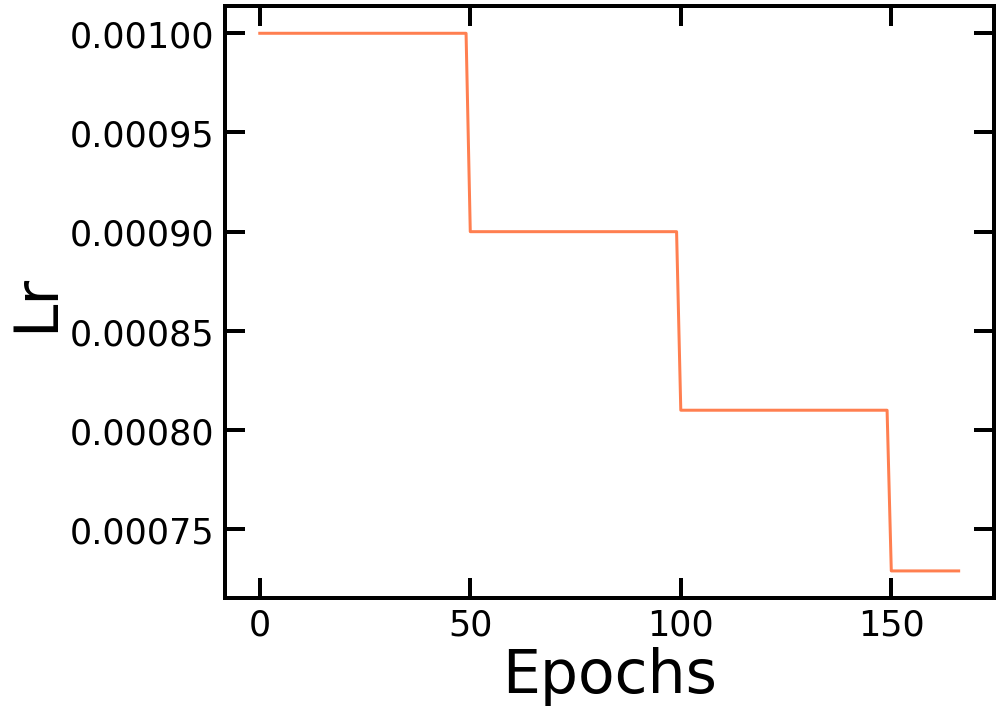

In [77]:
fig, axs = plt.subplots(1,1, figsize=(14,10))

axs.plot(clf1.history['lr'], linewidth=3, color = 'coral')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Lr', fontsize=60)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Epochs', fontsize=60)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=35)

plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/sleeptabnet_lr_no_txt_no_call.svg', bbox_inches='tight')

In [90]:
feat_importances_tabnet = pd.DataFrame(zip(important_features, 
                                             clf1.feature_importances_), 
                                         columns = ['Features', 'Importance'])

In [91]:
feat_importances_tabnet

,Features,Importance
0,Mean_Activity_inference,0.019257
1,Std_Activity_inference,0.028371
2,Skew_Activity_inference,0.026692
3,Var_Activity_inference,0.027811
4,Sum_Activity_inference,0.018640
5,Std_audio_inference,0.012752
6,Skew_audio_inference,0.016491
7,Var_audio_inference,0.026803
8,Sum_audio_inference,0.038833
9,Std_conv_duration,0.028387


In [54]:
ordered_feat_imp_tabnet = feat_importances_tabnet.sort_values(by = ['Importance'])
ordered_feat_imp_tabnet = ordered_feat_imp_tabnet.reset_index()

In [66]:
ordered_feat_imp_tabnet

,index,Features,Importance
0,36,Median_phone_lock_duration,0.008190
1,44,Sum_pic_id,0.011035
2,5,Std_audio_inference,0.012752
3,11,Min_conv_duration,0.013684
4,17,Mean_latitude,0.014254
5,22,Median_longitude,0.014431
6,38,Max_phone_lock_duration,0.014854
7,20,Std_travelstate,0.015838
8,45,Mean_number_social,0.016070
9,6,Skew_audio_inference,0.016491


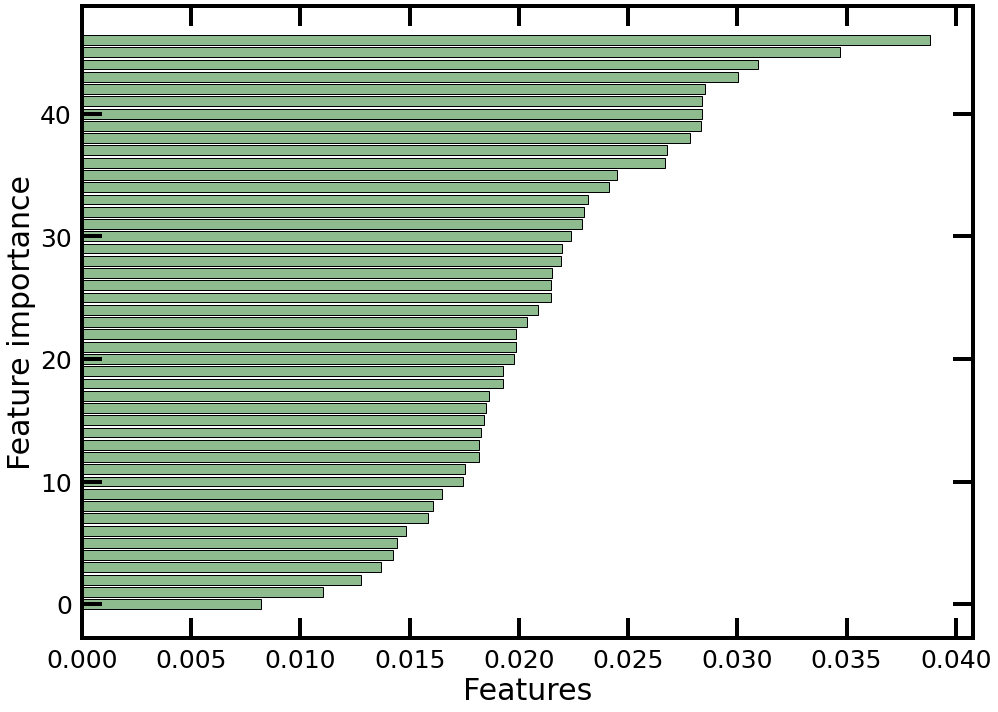

In [55]:
fig, axs = plt.subplots(1,1, figsize=(14,10))


axs.barh(ordered_feat_imp_tabnet.index, ordered_feat_imp_tabnet['Importance'], 
        ec='black', color='darkseagreen')

for axis in ['top','bottom','left','right']:
    axs.spines[axis].set_linewidth(4)
    
#axs.grid(True)
axs.set_ylabel('Feature importance', fontsize=30)
axs.xaxis.set_ticks_position('both')
axs.set_xlabel('Features', fontsize=30)
axs.yaxis.set_ticks_position('both')
axs.tick_params(which='both', length=20, width=4, direction="in", pad=10)


axs.tick_params(labelsize=25)

plt.tight_layout()
#fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/tabnet_feat_imp_no_txt_no_call.svg', bbox_inches='tight')

In [58]:
explain_matrix, masks = clf1.explain(X_val)

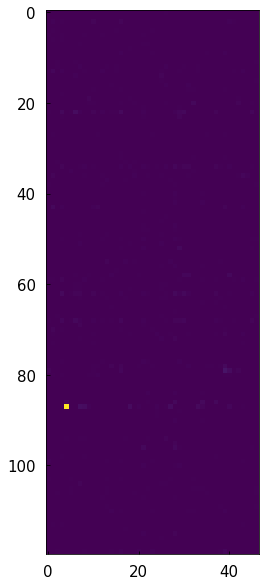

In [59]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.tick_params(which='both', direction="in", pad=10)
axs.tick_params(labelsize=15)
axs.imshow(explain_matrix)

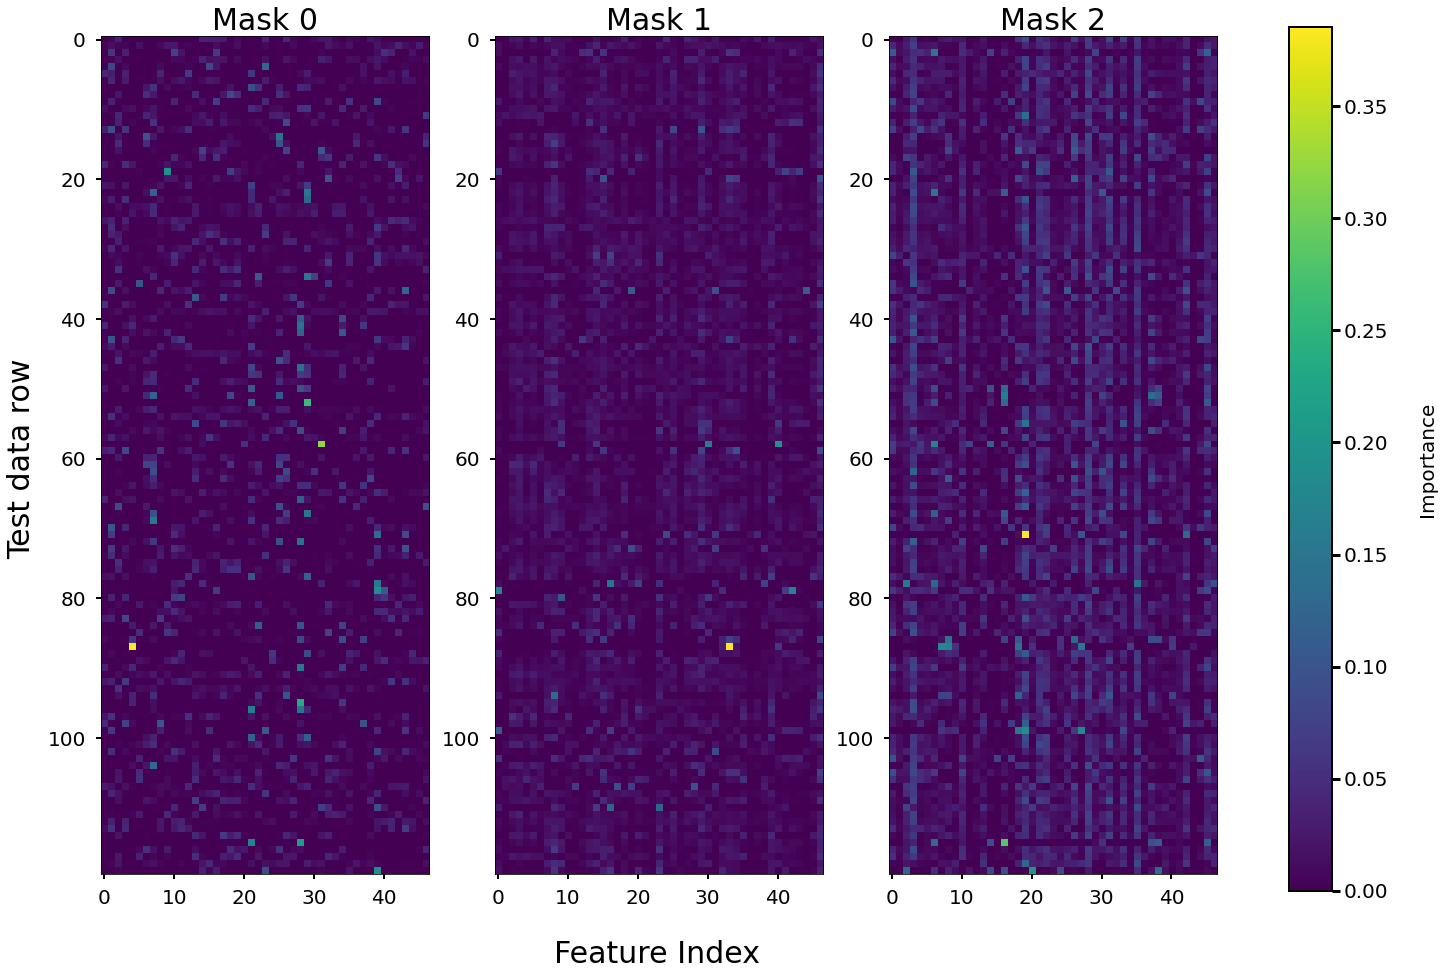

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    
    #axs[i].set_ylabel('Test Data Row', fontsize=30)
    #axs[i].set_xlabel('Feature index', fontsize=30)

    axs[i].tick_params(which='both', direction="out", pad=10,length=5, width=2)
    axs[i].tick_params(labelsize=20)
    im = axs[i].imshow(masks[i])
    axs[i].set_title(f"Mask {i}", fontsize=30)
    
fig.text(0.44, 0.15, 'Feature Index', fontsize=30)
fig.text(0.06, 0.5, 'Test data row', va='center', rotation='vertical', fontsize=30)

cax = fig.add_axes([0.95, 0.2, 0.03, 0.6])
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=20, length=8, width=3)
cb.outline.set_linewidth(2)
cb.set_label('Importance', fontsize = 20, rotation = 'vertical', labelpad=30)
fig.savefig('/home/diogo_mota/Dropbox/QMUL/MSc_Project/stress_tabnet_masks_no_txt_no_call.svg', bbox_inches='tight')

In [135]:
#clf2 = TabNetClassifier(
#clf2_params = {'optimizer_fn':[torch.optim.Adam, torch.optim.Adamax],
 #            'optimizer_params':[dict(lr=2e-2), dict(lr=1e-2)],
  #             'n_steps':[3,5], 'momentum':[0.02, 0.05],
   #          'scheduler_params':[{"step_size":50, "gamma":0.9},{"step_size":10, "gamma":0.9}],
    #         'scheduler_fn': [torch.optim.lr_scheduler.LambdaLR, torch.optim.lr_scheduler.StepLR],
     #        'mask_type':['entmax', 'sparsemax']}
    
#clf_grid = GridSearchCV(clf2, clf2_params, scoring = sklearn.metrics.accuracy_score,
 #                       refit=True, n_jobs = -1, verbose=1)
#clf_grid.fit(
 #   X_train,y_train,
  #  eval_set=[(X_train, y_train), (X_val, y_val)],
   # eval_name=['train', 'valid'],
    #eval_metric=['auc'],
    #max_epochs=1000 , patience=50,
    #batch_size=256, virtual_batch_size=128,
    #num_workers=0,
    #weights=1,
    #drop_last=False
#)

In [137]:
#print('Best estimator:', clf_grid.best_estimator_)

Best estimator: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.LambdaLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='entmax', input_dim=22, output_dim=2, device_name='auto')
